In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import Input
from keras import backend as K
from keras import layers
from keras.layers import LSTM, Dense
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

from spec_generator_sequence import spec_generator
from spec_generator_sequence_multilabel import spec_generator_multi, spec_generator_multioutput
from spec_input_generator import gen, gen_eval
from spectrogram_class import spectrogram


In [2]:
meta_df = pd.read_csv('../data/OrchideaSOL_metadata.csv')

In [3]:
meta_df.shape

(13265, 17)

In [4]:
meta_df = meta_df[~meta_df['Pitch ID (if applicable)'].isna()]

In [5]:
meta_df.isna().sum()

Path                              0
Family (abbr.)                    0
Family (in full)                  0
Instrument (abbr.)                0
Instrument (in full)              0
Technique (abbr.)                 0
Technique (in full)               0
Pitch                             0
Pitch ID (if applicable)          0
Dynamics                          0
Dynamics ID (if applicable)     568
Instance ID                       0
Mute (abbr.)                      0
Mute (in full)                    0
String ID (if applicable)      5666
Needed digital retuning           0
Fold                              0
dtype: int64

In [6]:
meta_df.shape

(13162, 17)

In [7]:
meta_df.head(2)

,Path,Family (abbr.),Family (in full),Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID (if applicable),Dynamics,Dynamics ID (if applicable),Instance ID,Mute (abbr.),Mute (in full),String ID (if applicable),Needed digital retuning,Fold
0,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,f,3.0,0.0,S,Sordina,NaN,False,2
1,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,p,1.0,0.0,S,Sordina,NaN,True,0


In [8]:
from random import random


train_df, test_df = train_test_split(meta_df, stratify=meta_df['Instrument (in full)'], 
                                            train_size=0.7, random_state= 42)

In [9]:
train_df[['Instrument (in full)', 'Pitch ID (if applicable)']]

,Instrument (in full),Pitch ID (if applicable)
4794,Contrabass,43.0
6427,Viola,62.0
10717,Cello,42.0
7699,Violin,69.0
5254,Contrabass,44.0
...,...,...
1681,Trombone,46.0
4206,Contrabass,53.0
6293,Viola,57.0
4274,Contrabass,66.0


In [10]:
label = LabelEncoder()
multi = MultiLabelBinarizer()

multi.fit_transform(train_df[['Instrument (in full)', 'Pitch ID (if applicable)']])

array([[1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0]])

In [11]:
train_df['target'] = [[i, str(j)] for i,j in zip(train_df['Instrument (in full)'], train_df['Pitch ID (if applicable)'])]

In [12]:
train_df['target']

4794     [Contrabass, 43.0]
6427          [Viola, 62.0]
10717         [Cello, 42.0]
7699         [Violin, 69.0]
5254     [Contrabass, 44.0]
                ...        
1681       [Trombone, 46.0]
4206     [Contrabass, 53.0]
6293          [Viola, 57.0]
4274     [Contrabass, 66.0]
2950      [Accordion, 78.0]
Name: target, Length: 9213, dtype: object

In [13]:
multi_2 = MultiLabelBinarizer()

In [14]:
len(train_df['Instrument (in full)'].unique())

16

In [15]:
len(train_df['Pitch ID (if applicable)'].unique())

90

In [16]:
multi_2.fit_transform(train_df['target']).shape

(9213, 106)

In [17]:
multi.classes_

array([' ', '(', ')', 'D', 'I', 'P', 'a', 'b', 'c', 'e', 'f', 'h', 'i',
       'l', 'm', 'n', 'p', 'r', 's', 't', 'u'], dtype=object)

In [18]:
multi_generator = spec_generator_multi(train_df, 32)

In [19]:
_, num_target = multi_generator.__getitem__(2)[1].shape
print(num_target)

107


In [20]:
_, num_row, num_col= multi_generator.__getitem__(2)[0].shape
print(num_row)
print(num_col)

500
256


In [21]:
BATCH_SIZE = 32


train_generator = (tf.data.Dataset.from_generator(lambda: spec_generator_multi(train_df, BATCH_SIZE), output_types=(tf.complex64, tf.int64), 
                 output_shapes = ((BATCH_SIZE, num_row, num_col), 
                 (BATCH_SIZE, num_target)))).prefetch((tf.data.experimental.AUTOTUNE))

eval_generator = (tf.data.Dataset.from_generator(lambda: spec_generator_multi(test_df, BATCH_SIZE), 
                    output_types=(tf.complex64, tf.int64), 
                 output_shapes = ((BATCH_SIZE, num_row, num_col), 
                 (BATCH_SIZE, num_target)))).prefetch((tf.data.experimental.AUTOTUNE))


2022-07-21 23:43:47.415922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 23:43:47.451708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 23:43:47.452139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 23:43:47.453031: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [22]:


rnn = Sequential()

rnn.add(layers.InputLayer((num_row, num_col), batch_size= BATCH_SIZE))
rnn.add(LSTM(500))
rnn.add(layers.Dropout(0.2))
rnn.add(layers.Dense(50, activation = 'relu'))
rnn.add(layers.Dense(num_target, activation = 'sigmoid'))



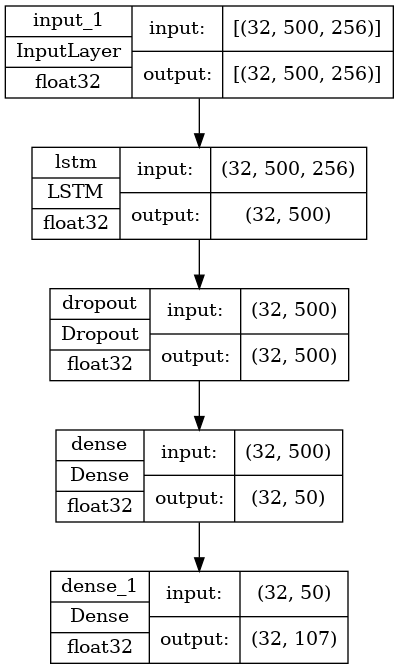

In [23]:
tf.keras.utils.plot_model(rnn, show_shapes = True, show_dtype= True)

In [24]:
rnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision()])

In [26]:
from datetime import datetime

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    f"../models/baseline_checkpoint/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{{epoch:02d}}_rnn", 
                                                    monitor='val_accuracy')
early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 2)


history = rnn.fit(train_generator, epochs = 4, verbose=1, 
                    validation_data = eval_generator,
                    validation_steps = 10, validation_freq= 2, 
                    use_multiprocessing=True, workers = 2, callbacks=[ckpt_callback, early_callback])

Epoch 1/4


2022-07-21 22:26:04.912618: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32768000 exceeds 10% of free system memory.
2022-07-21 22:26:05.575817: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


      2/Unknown - 4s 172ms/step - loss: 0.6768 - accuracy: 0.0000e+00 - auc: 0.5040 - precision: 0.0198

2022-07-21 22:26:06.771392: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32768000 exceeds 10% of free system memory.
2022-07-21 22:26:06.943633: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32768000 exceeds 10% of free system memory.


      5/Unknown - 4s 164ms/step - loss: 0.4977 - accuracy: 0.0125 - auc: 0.5075 - precision: 0.0198  

2022-07-21 22:26:07.256365: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32768000 exceeds 10% of free system memory.


      7/Unknown - 5s 163ms/step - loss: 0.4066 - accuracy: 0.0134 - auc: 0.5258 - precision: 0.0214

2022-07-21 22:26:07.567652: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32768000 exceeds 10% of free system memory.


    287/Unknown - 50s 162ms/step - loss: 0.0952 - accuracy: 0.0011 - auc: 0.7291 - precision: 0.0239

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220721_222602_01_rnn/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220721_222602_01_rnn/assets


287/287 [==============================] - 57s 186ms/step - loss: 0.0952 - accuracy: 0.0011 - auc: 0.7291 - precision: 0.0239
Epoch 2/4
287/287 [==============================] - ETA: 0s - loss: 0.0824 - accuracy: 0.0000e+00 - auc: 0.7632 - precision: 0.5000

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220721_222602_02_rnn/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220721_222602_02_rnn/assets


287/287 [==============================] - 56s 195ms/step - loss: 0.0824 - accuracy: 0.0000e+00 - auc: 0.7632 - precision: 0.5000 - val_loss: 0.0790 - val_accuracy: 0.0000e+00 - val_auc: 0.7978 - val_precision: 0.7222
Epoch 3/4
287/287 [==============================] - ETA: 0s - loss: 0.0801 - accuracy: 0.0000e+00 - auc: 0.7866 - precision: 0.5857

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220721_222602_03_rnn/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220721_222602_03_rnn/assets


287/287 [==============================] - 60s 209ms/step - loss: 0.0801 - accuracy: 0.0000e+00 - auc: 0.7866 - precision: 0.5857


In [25]:
test = meta_df.sample(1)[['Path', 'Instrument (in full)', 'Pitch ID (if applicable)']]

In [26]:
test

,Path,Instrument (in full),Pitch ID (if applicable)
7422,Strings/Viola/tremolo/Va-trem-B4-ff-3c-N.wav,Viola,71.0


In [27]:
test_spec = spectrogram(test['Path'].values[0])

In [28]:
test_spec.spec

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
test_spec.spec.shape

(256, 500)

In [30]:
np.reshape(test_spec.spec, (256, 500, 1)).shape

(256, 500, 1)

In [31]:
np.reshape(multi_generator.__getitem__(2)[0]).shape

TypeError: _reshape_dispatcher() missing 1 required positional argument: 'newshape'

In [ ]:
rnn.predict_(multi_generator.__getitem__(2)[0])[0]

1/1 [==============================] - 0s 35ms/step


array([0.00260453, 0.0005687 , 0.00055939, 0.00070645, 0.00212344,
       0.00209092, 0.00076596, 0.00086604, 0.00232595, 0.00059876,
       0.00055543, 0.00040937, 0.00020813, 0.00070759, 0.00256349,
       0.00275815, 0.00172904, 0.00052593, 0.00719799, 0.00512902,
       0.00112033, 0.00474609, 0.00487907, 0.01241985, 0.00651898,
       0.00714459, 0.00492266, 0.00378284, 0.0041289 , 0.00875445,
       0.00663424, 0.00509705, 0.00700022, 0.02220988, 0.00909952,
       0.00190063, 0.00916105, 0.00349951, 0.0099712 , 0.00689452,
       0.00729102, 0.00720703, 0.00337747, 0.00523437, 0.00536347,
       0.01170427, 0.0165459 , 0.02236199, 0.01643208, 0.00229629,
       0.01995986, 0.03674094, 0.0113699 , 0.00882796, 0.02286237,
       0.01461896, 0.01132258, 0.00916229, 0.01118264, 0.01318029,
       0.02608438, 0.02820007, 0.02263157, 0.00697275, 0.00730005,
       0.03116695, 0.00509924, 0.0111141 , 0.01153703, 0.00677821,
       0.01254568, 0.00330228, 0.03986355, 0.01642948, 0.02432

In [ ]:
multi_generator.__getitem__(2)[0][0].shape

(500, 256, 1)

# Rnn two onte-hot target

In [27]:
from unicodedata import name


inp = Input((num_row, num_col), batch_size=BATCH_SIZE, )
x = LSTM(500)(inp)
x = layers.Dropout(0.2)(x)
x = layers.Dense(50, activation = 'relu')(x)
out1 = layers.Dense(16, activation = 'softmax', name = 'out1')(x)

y = LSTM(500)(inp)
y = layers.Dropout(0.2)(y)
y = layers.Dense(50, activation = 'relu')(y)
out2 = layers.Dense(107-16, activation = 'softmax', name = 'out2')(y)

model_2conv_two_out = Model(inp, [out1, out2])

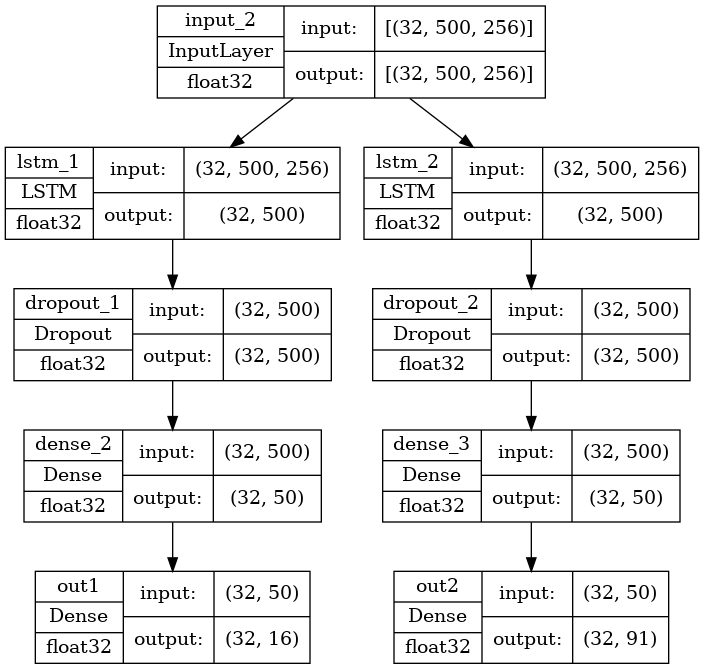

In [28]:
tf.keras.utils.plot_model(model_2conv_two_out, show_shapes=True, show_dtype=True)

In [32]:
model_2conv_two_out.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(32, 500, 256)]     0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (32, 500)            1514000     ['input_2[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  (32, 500)            1514000     ['input_2[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (32, 500)            0           ['lstm_1[0][0]']                 
                                                                                              

In [29]:
model_2conv_two_out.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss={'out1': tf.keras.losses.CategoricalCrossentropy(),
                    'out2': tf.keras.losses.CategoricalCrossentropy()},
              metrics=['accuracy', tf.keras.metrics.AUC()])

In [30]:
multioutput_generator = spec_generator_multioutput(train_df, 32)
multioutput_test_generator = spec_generator_multioutput(test_df, 32)

In [34]:
from datetime import datetime

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    f"../models/baseline_checkpoint/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{{epoch:02d}}_rnn_multioutput", 
                                                    monitor='val_accuracy')
early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 2)

history = model_2conv_two_out.fit(multioutput_generator, epochs=10, 
                        validation_data= multioutput_test_generator, 
                        callbacks=[ckpt_callback, early_callback])

Epoch 1/10
287/287 [==============================] - ETA: 0s - loss: 4.3146 - out1_loss: 2.3358 - out2_loss: 1.9789 - out1_accuracy: 0.2386 - out1_auc_1: 0.7636 - out2_accuracy: 0.4943 - out2_auc_1: 0.9474

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220722_053940_01_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220722_053940_01_rnn_multioutput/assets


287/287 [==============================] - 115s 399ms/step - loss: 4.3146 - out1_loss: 2.3358 - out2_loss: 1.9789 - out1_accuracy: 0.2386 - out1_auc_1: 0.7636 - out2_accuracy: 0.4943 - out2_auc_1: 0.9474 - val_loss: 4.4017 - val_out1_loss: 2.3383 - val_out2_loss: 2.0634 - val_out1_accuracy: 0.2403 - val_out1_auc_1: 0.7597 - val_out2_accuracy: 0.4842 - val_out2_auc_1: 0.9414
Epoch 2/10
287/287 [==============================] - ETA: 0s - loss: 4.1081 - out1_loss: 2.2777 - out2_loss: 1.8304 - out1_accuracy: 0.2513 - out1_auc_1: 0.7798 - out2_accuracy: 0.5302 - out2_auc_1: 0.9539

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220722_053940_02_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220722_053940_02_rnn_multioutput/assets


287/287 [==============================] - 129s 450ms/step - loss: 4.1081 - out1_loss: 2.2777 - out2_loss: 1.8304 - out1_accuracy: 0.2513 - out1_auc_1: 0.7798 - out2_accuracy: 0.5302 - out2_auc_1: 0.9539 - val_loss: 4.2529 - val_out1_loss: 2.2809 - val_out2_loss: 1.9720 - val_out1_accuracy: 0.2624 - val_out1_auc_1: 0.7836 - val_out2_accuracy: 0.5191 - val_out2_auc_1: 0.9433
Epoch 3/10
287/287 [==============================] - ETA: 0s - loss: 3.9770 - out1_loss: 2.2384 - out2_loss: 1.7386 - out1_accuracy: 0.2651 - out1_auc_1: 0.7905 - out2_accuracy: 0.5522 - out2_auc_1: 0.9577

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220722_053940_03_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220722_053940_03_rnn_multioutput/assets


287/287 [==============================] - 136s 471ms/step - loss: 3.9770 - out1_loss: 2.2384 - out2_loss: 1.7386 - out1_accuracy: 0.2651 - out1_auc_1: 0.7905 - out2_accuracy: 0.5522 - out2_auc_1: 0.9577 - val_loss: 4.0961 - val_out1_loss: 2.2309 - val_out2_loss: 1.8652 - val_out1_accuracy: 0.2683 - val_out1_auc_1: 0.7932 - val_out2_accuracy: 0.5450 - val_out2_auc_1: 0.9444
Epoch 4/10
287/287 [==============================] - ETA: 0s - loss: 3.9447 - out1_loss: 2.1978 - out2_loss: 1.7469 - out1_accuracy: 0.2681 - out1_auc_1: 0.8012 - out2_accuracy: 0.5566 - out2_auc_1: 0.9552

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220722_053940_04_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220722_053940_04_rnn_multioutput/assets


287/287 [==============================] - 147s 512ms/step - loss: 3.9447 - out1_loss: 2.1978 - out2_loss: 1.7469 - out1_accuracy: 0.2681 - out1_auc_1: 0.8012 - out2_accuracy: 0.5566 - out2_auc_1: 0.9552 - val_loss: 3.9395 - val_out1_loss: 2.1861 - val_out2_loss: 1.7534 - val_out1_accuracy: 0.2891 - val_out1_auc_1: 0.8015 - val_out2_accuracy: 0.5722 - val_out2_auc_1: 0.9527
Epoch 5/10
287/287 [==============================] - ETA: 0s - loss: 3.8131 - out1_loss: 2.1803 - out2_loss: 1.6328 - out1_accuracy: 0.2758 - out1_auc_1: 0.8048 - out2_accuracy: 0.5811 - out2_auc_1: 0.9618

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220722_053940_05_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220722_053940_05_rnn_multioutput/assets


287/287 [==============================] - 151s 525ms/step - loss: 3.8131 - out1_loss: 2.1803 - out2_loss: 1.6328 - out1_accuracy: 0.2758 - out1_auc_1: 0.8048 - out2_accuracy: 0.5811 - out2_auc_1: 0.9618 - val_loss: 3.9650 - val_out1_loss: 2.2202 - val_out2_loss: 1.7448 - val_out1_accuracy: 0.2805 - val_out1_auc_1: 0.7963 - val_out2_accuracy: 0.5752 - val_out2_auc_1: 0.9548
Epoch 6/10
287/287 [==============================] - ETA: 0s - loss: 3.6171 - out1_loss: 2.1435 - out2_loss: 1.4735 - out1_accuracy: 0.2829 - out1_auc_1: 0.8138 - out2_accuracy: 0.6141 - out2_auc_1: 0.9659

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220722_053940_06_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220722_053940_06_rnn_multioutput/assets


287/287 [==============================] - 150s 523ms/step - loss: 3.6171 - out1_loss: 2.1435 - out2_loss: 1.4735 - out1_accuracy: 0.2829 - out1_auc_1: 0.8138 - out2_accuracy: 0.6141 - out2_auc_1: 0.9659 - val_loss: 3.8540 - val_out1_loss: 2.1306 - val_out2_loss: 1.7234 - val_out1_accuracy: 0.2950 - val_out1_auc_1: 0.8158 - val_out2_accuracy: 0.5716 - val_out2_auc_1: 0.9529
Epoch 7/10
287/287 [==============================] - ETA: 0s - loss: 3.6569 - out1_loss: 2.2151 - out2_loss: 1.4418 - out1_accuracy: 0.2547 - out1_auc_1: 0.7953 - out2_accuracy: 0.6255 - out2_auc_1: 0.9689

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220722_053940_07_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220722_053940_07_rnn_multioutput/assets


287/287 [==============================] - 160s 556ms/step - loss: 3.6569 - out1_loss: 2.2151 - out2_loss: 1.4418 - out1_accuracy: 0.2547 - out1_auc_1: 0.7953 - out2_accuracy: 0.6255 - out2_auc_1: 0.9689 - val_loss: 3.8415 - val_out1_loss: 2.1966 - val_out2_loss: 1.6449 - val_out1_accuracy: 0.2609 - val_out1_auc_1: 0.8003 - val_out2_accuracy: 0.6037 - val_out2_auc_1: 0.9538
Epoch 8/10
287/287 [==============================] - ETA: 0s - loss: 3.5349 - out1_loss: 2.1615 - out2_loss: 1.3734 - out1_accuracy: 0.2729 - out1_auc_1: 0.8087 - out2_accuracy: 0.6384 - out2_auc_1: 0.9707

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220722_053940_08_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220722_053940_08_rnn_multioutput/assets


287/287 [==============================] - 162s 566ms/step - loss: 3.5349 - out1_loss: 2.1615 - out2_loss: 1.3734 - out1_accuracy: 0.2729 - out1_auc_1: 0.8087 - out2_accuracy: 0.6384 - out2_auc_1: 0.9707 - val_loss: 3.7891 - val_out1_loss: 2.1627 - val_out2_loss: 1.6264 - val_out1_accuracy: 0.2782 - val_out1_auc_1: 0.8070 - val_out2_accuracy: 0.5986 - val_out2_auc_1: 0.9590
Epoch 9/10
287/287 [==============================] - ETA: 0s - loss: 3.4386 - out1_loss: 2.1165 - out2_loss: 1.3220 - out1_accuracy: 0.2925 - out1_auc_1: 0.8186 - out2_accuracy: 0.6548 - out2_auc_1: 0.9729

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220722_053940_09_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220722_053940_09_rnn_multioutput/assets


287/287 [==============================] - 160s 559ms/step - loss: 3.4386 - out1_loss: 2.1165 - out2_loss: 1.3220 - out1_accuracy: 0.2925 - out1_auc_1: 0.8186 - out2_accuracy: 0.6548 - out2_auc_1: 0.9729 - val_loss: 3.8032 - val_out1_loss: 2.1340 - val_out2_loss: 1.6692 - val_out1_accuracy: 0.2823 - val_out1_auc_1: 0.8131 - val_out2_accuracy: 0.5925 - val_out2_auc_1: 0.9543
Epoch 10/10
287/287 [==============================] - ETA: 0s - loss: 3.4468 - out1_loss: 2.1193 - out2_loss: 1.3275 - out1_accuracy: 0.2867 - out1_auc_1: 0.8183 - out2_accuracy: 0.6447 - out2_auc_1: 0.9740

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220722_053940_10_rnn_multioutput/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220722_053940_10_rnn_multioutput/assets


287/287 [==============================] - 166s 579ms/step - loss: 3.4468 - out1_loss: 2.1193 - out2_loss: 1.3275 - out1_accuracy: 0.2867 - out1_auc_1: 0.8183 - out2_accuracy: 0.6447 - out2_auc_1: 0.9740 - val_loss: 3.6860 - val_out1_loss: 2.1302 - val_out2_loss: 1.5559 - val_out1_accuracy: 0.2848 - val_out1_auc_1: 0.8147 - val_out2_accuracy: 0.6232 - val_out2_auc_1: 0.9568


In [40]:
model_2conv_two_out.save('../models/rnn/first')

INFO:tensorflow:Assets written to: ../models/rnn/first/assets


INFO:tensorflow:Assets written to: ../models/rnn/first/assets


In [36]:
%load_ext tensorboard

In [38]:
!tensorboard dev upload \
    -y \
  --logdir logs \
  --name "Sample op-level graph" \
  --one_shot

/bin/bash: /home/shiya/anaconda3/envs/music/lib/libtinfo.so.6: no version information available (required by /bin/bash)
usage: tensorboard [-h] [--helpfull] {serve,dev} ...
tensorboard: error: unrecognized arguments: -y
